In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
from pprint import pprint

In [2]:
def indicators(df: pd.DataFrame):
    close = df["close"]
    high = df["high"]
    low = df["low"]
    volume = df["volume"]

    df["ema12"] = close.ewm(span=12).mean()
    df["ema26"] = close.ewm(span=26).mean()
    df["macd"] = df["ema12"] - df["ema26"]
    df["macd_signal"] = df["macd"].ewm(span=9).mean()

    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    atr = tr.rolling(window=14).mean()
    plus_dm = (high - high.shift(1)).clip(lower=0)
    minus_dm = (low.shift(1) - low).clip(lower=0)
    plus_di = 100 * (plus_dm.rolling(14).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(14).mean() / atr)
    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    df["adx"] = dx.rolling(14).mean()

    delta = close.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain / (loss + 1e-5)
    df["rsi"] = 100 - (100 / (1 + rs))

    ll = low.rolling(14).min()
    hh = high.rolling(14).max()
    k = 100 * ((close - ll) / (hh - ll + 1e-5))
    df["slowk"] = k
    df["slowd"] = k.rolling(3).mean()

    df["roc"] = 100 * (close - close.shift(10)) / close.shift(10)

    ma = close.rolling(20).mean()
    std = close.rolling(20).std()
    upper = ma + 2 * std
    lower = ma - 2 * std
    df["bb_upper"] = upper
    df["bb_middle"] = ma
    df["bb_lower"] = lower
    df["bb_percent_b"] = (close - lower) / (upper - lower + 1e-5)

    df["atr"] = atr

    direction = close.diff().apply(np.sign)
    df["obv"] = (direction * volume).fillna(0).cumsum()

    tp = (high + low + close) / 3
    mf = tp * volume
    pos_mf = mf.where(tp.diff() > 0, 0.0)
    neg_mf = mf.where(tp.diff() < 0, 0.0)
    pos_sum = pos_mf.rolling(14).sum()
    neg_sum = neg_mf.rolling(14).sum()
    mfr = pos_sum / (neg_sum + 1e-5)
    df["mfi"] = 100 - (100 / (1 + mfr))

    df["vwap"] = (tp * volume).cumsum() / volume.cumsum()

    return df.dropna()

def fetch_stock_data(symbols, seq_len=2048, horizon=3):
    def label_direction(pct_change, threshold=1.0):
        if pct_change > threshold:
            return 1  # Buy
        elif pct_change < -threshold:
            return 2  # Sell
        else:
            return 0
    result = {}
    for symbol in symbols:
        df = yf.download(symbol, interval="5m", period="16d", progress=False, auto_adjust=False)

        if isinstance(df.columns, pd.MultiIndex):
            df = df.xs(symbol, axis=1, level=1)

        df = df.rename(columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume"
        })[["open", "high", "low", "close", "volume"]]

        df = indicators(df)

        if len(df) > seq_len + horizon:
            df = df.iloc[-seq_len - horizon:]

        close = df["close"]
        future = close.shift(-horizon)
        pct_change = ((future - close) / close) * 100
        threshold = (df["atr"].mean() / df["close"].mean()) * 100

        # horizon = 3
        # pct_changes = df["close"].pct_change(periods=horizon).abs() * 100
        # threshold = pct_changes.quantile(0.75)  # Use the 75th percentile

        df.loc[:, "label"] = pct_change.apply(lambda x: label_direction(x, threshold))
        df = df.drop(columns=["open", "high", "low"]).dropna()

        numeric = df.drop(columns=["label"])
        normalized = (numeric - numeric.mean()) / (numeric.std() + 1e-6)
        normalized["label"] = df["label"]

        result[symbol] = normalized.reset_index(drop=True)

    return result

class SequenceDataset(Dataset):
    def __init__(self, df: pd.DataFrame, window_size=60):
        arr = df.drop(columns=["label"]).values
        labels = df["label"].values.astype(int)
        self.X = []
        self.y = []
        for i in range(len(arr) - window_size):
            self.X.append(arr[i:i+window_size])
            self.y.append(labels[i + window_size])
        self.X = torch.tensor(np.stack(self.X), dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
label_map = {0: "Hold", 1: "Buy", 2: "Sell"}

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_classes=3, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.prelu = nn.PReLU()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.PReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1]
        out = self.prelu(out)
        return self.classifier(out)

def train_model(df: pd.DataFrame, window_size: int, epochs: int):
    ds = SequenceDataset(df, window_size=window_size)
    train_loader = DataLoader(ds, batch_size=32, shuffle=True)

    model = LSTMClassifier(input_dim=df.shape[1] - 1)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    labels_np = ds.y.numpy()
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_np), y=labels_np)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        for X, y in train_loader:
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    return model

def infer_model(model: nn.Module, df: pd.DataFrame, window_size: int):
    ds = SequenceDataset(df, window_size=window_size)
    model.eval()
    with torch.no_grad():
        preds = model(ds.X).argmax(dim=1).cpu().numpy()
    return preds, df["close"].values[window_size:]

def plot_predictions(prices, preds, symbol):
    times = np.arange(len(prices))

    hold_idx = [i for i, p in enumerate(preds) if p == 0]
    buy_idx = [i for i, p in enumerate(preds) if p == 1]
    sell_idx = [i for i, p in enumerate(preds) if p == 2]

    plt.figure(figsize=(12, 4))
    plt.plot(times, prices, label=f"{symbol} Price", color="black")
    plt.scatter(times[buy_idx], prices[buy_idx], color="green", label="Buy", marker="^")
    plt.scatter(times[sell_idx], prices[sell_idx], color="red", label="Sell", marker="v")
    plt.scatter(times[hold_idx], prices[hold_idx], color="gray", label="Hold", marker="o", alpha=0.5)
    plt.title(f"{symbol} - Model Predictions")
    plt.xlabel("Time (5-min intervals)")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
def format_floats(obj):
    if isinstance(obj, dict):
        return {k: format_floats(v) for k, v in obj.items()}
    elif isinstance(obj, float):
        return f"{obj:.4f}"
    else:
        return obj

window_size = 60
symbols = ["AAPL", "BLK", "GOOGL", "NVDA", "TSLA"]
data = fetch_stock_data(symbols)

results = {}

for symbol in symbols:
    print(f"Processing symbol: {symbol}")
    df = data[symbol]

    start = time()
    model = train_model(df, window_size, epochs=32)
    print(f"Trained {symbol} model in {time() - start:.2f}s")

    preds, prices = infer_model(model, df, window_size)
    true_labels = df["label"].values[window_size:]

    results[symbol] = {
        "model": model,
        "predictions": preds,
        "true_labels": true_labels,
        "prices": prices,
        "balanced_accuracy": balanced_accuracy_score(true_labels, preds),
        "classification_report": classification_report(true_labels, preds, output_dict=True),
        "confusion_matrix": confusion_matrix(true_labels, preds),
    }

Processing symbol: AAPL
Trained AAPL model in 71.02s
Processing symbol: BLK
Trained BLK model in 61.18s
Processing symbol: GOOGL
Trained GOOGL model in 63.18s
Processing symbol: NVDA
Trained NVDA model in 62.95s
Processing symbol: TSLA
Trained TSLA model in 63.42s


Metrics for AAPL:

Balanced Accuracy: 0.7677

Classification Report:
{'0': {'f1-score': '0.9083',
       'precision': '0.8811',
       'recall': '0.9373',
       'support': '814.0000'},
 '1': {'f1-score': '0.7755',
       'precision': '0.8085',
       'recall': '0.7451',
       'support': '153.0000'},
 '2': {'f1-score': '0.7013',
       'precision': '0.8060',
       'recall': '0.6207',
       'support': '174.0000'},
 'accuracy': '0.8633',
 'macro avg': {'f1-score': '0.7950',
               'precision': '0.8318',
               'recall': '0.7677',
               'support': '1141.0000'},
 'weighted avg': {'f1-score': '0.8590',
                  'precision': '0.8599',
                  'recall': '0.8633',
                  'support': '1141.0000'}}

Confusion Matrix:
[[763  25  26]
 [ 39 114   0]
 [ 64   2 108]]


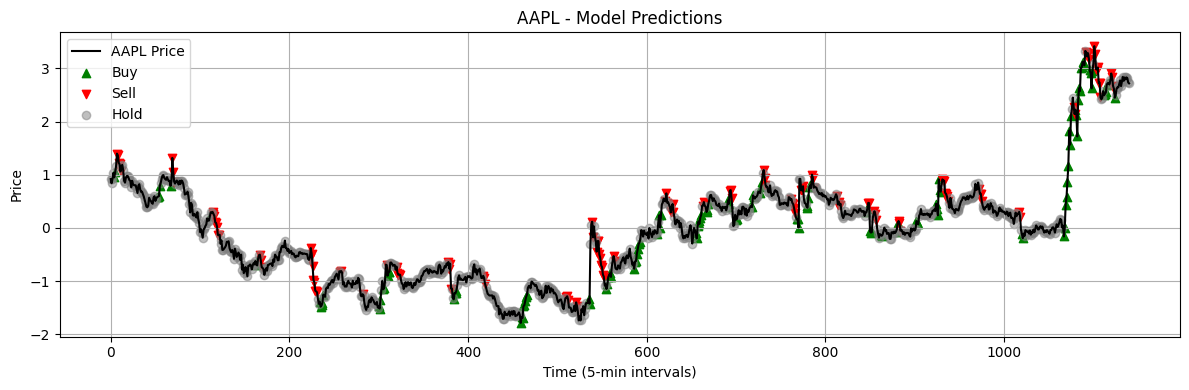

In [5]:
symbol = symbols[0]
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

print("\nClassification Report:")
pprint(format_floats(results[symbol]["classification_report"]))

print("\nConfusion Matrix:")
print(results[symbol]["confusion_matrix"])

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)

Metrics for BLK:

Balanced Accuracy: 0.8026

Classification Report:
{'0': {'f1-score': '0.8886',
       'precision': '0.8623',
       'recall': '0.9165',
       'support': '683.0000'},
 '1': {'f1-score': '0.8104',
       'precision': '0.8636',
       'recall': '0.7634',
       'support': '224.0000'},
 '2': {'f1-score': '0.7597',
       'precision': '0.7946',
       'recall': '0.7277',
       'support': '202.0000'},
 'accuracy': '0.8512',
 'macro avg': {'f1-score': '0.8196',
               'precision': '0.8402',
               'recall': '0.8026',
               'support': '1109.0000'},
 'weighted avg': {'f1-score': '0.8493',
                  'precision': '0.8502',
                  'recall': '0.8512',
                  'support': '1109.0000'}}

Confusion Matrix:
[[626  25  32]
 [ 47 171   6]
 [ 53   2 147]]


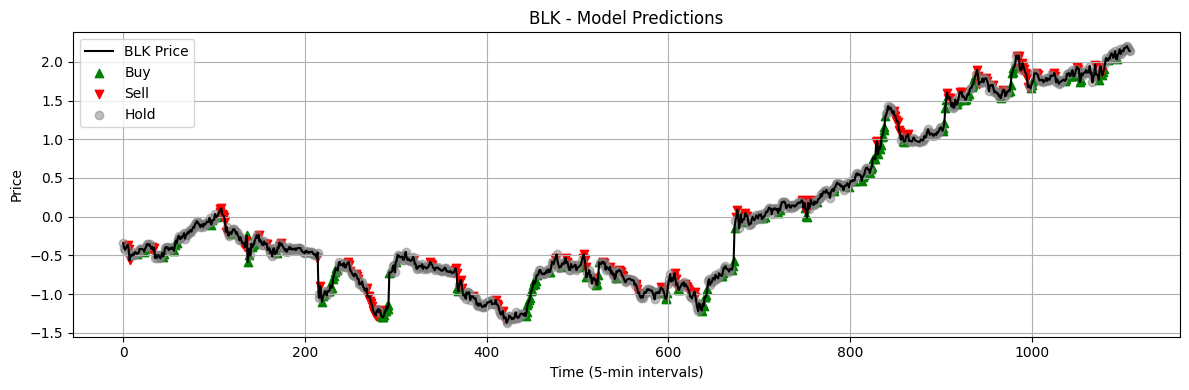

In [6]:
symbol = symbols[1]
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

print("\nClassification Report:")
pprint(format_floats(results[symbol]["classification_report"]))

print("\nConfusion Matrix:")
print(results[symbol]["confusion_matrix"])

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)

Metrics for GOOGL:

Balanced Accuracy: 0.7315

Classification Report:
{'0': {'f1-score': '0.8918',
       'precision': '0.8624',
       'recall': '0.9233',
       'support': '808.0000'},
 '1': {'f1-score': '0.7075',
       'precision': '0.7536',
       'recall': '0.6667',
       'support': '156.0000'},
 '2': {'f1-score': '0.6794',
       'precision': '0.7754',
       'recall': '0.6045',
       'support': '177.0000'},
 'accuracy': '0.8387',
 'macro avg': {'f1-score': '0.7596',
               'precision': '0.7971',
               'recall': '0.7315',
               'support': '1141.0000'},
 'weighted avg': {'f1-score': '0.8337',
                  'precision': '0.8340',
                  'recall': '0.8387',
                  'support': '1141.0000'}}

Confusion Matrix:
[[746  31  31]
 [ 52 104   0]
 [ 67   3 107]]


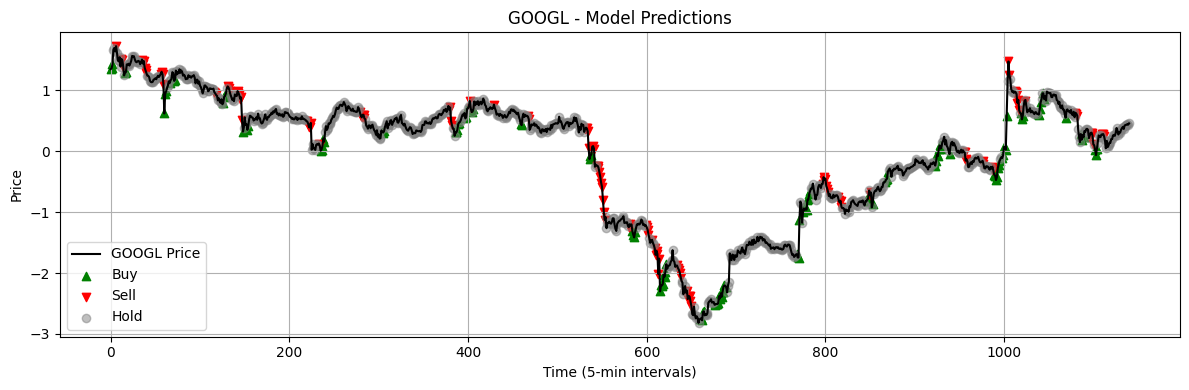

In [7]:
symbol = symbols[2]
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

print("\nClassification Report:")
pprint(format_floats(results[symbol]["classification_report"]))

print("\nConfusion Matrix:")
print(results[symbol]["confusion_matrix"])

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)

Metrics for NVDA:

Balanced Accuracy: 0.7564

Classification Report:
{'0': {'f1-score': '0.8748',
       'precision': '0.8815',
       'recall': '0.8683',
       'support': '797.0000'},
 '1': {'f1-score': '0.7264',
       'precision': '0.6609',
       'recall': '0.8063',
       'support': '191.0000'},
 '2': {'f1-score': '0.6594',
       'precision': '0.7398',
       'recall': '0.5948',
       'support': '153.0000'},
 'accuracy': '0.8212',
 'macro avg': {'f1-score': '0.7536',
               'precision': '0.7608',
               'recall': '0.7564',
               'support': '1141.0000'},
 'weighted avg': {'f1-score': '0.8211',
                  'precision': '0.8256',
                  'recall': '0.8212',
                  'support': '1141.0000'}}

Confusion Matrix:
[[692  75  30]
 [ 35 154   2]
 [ 58   4  91]]


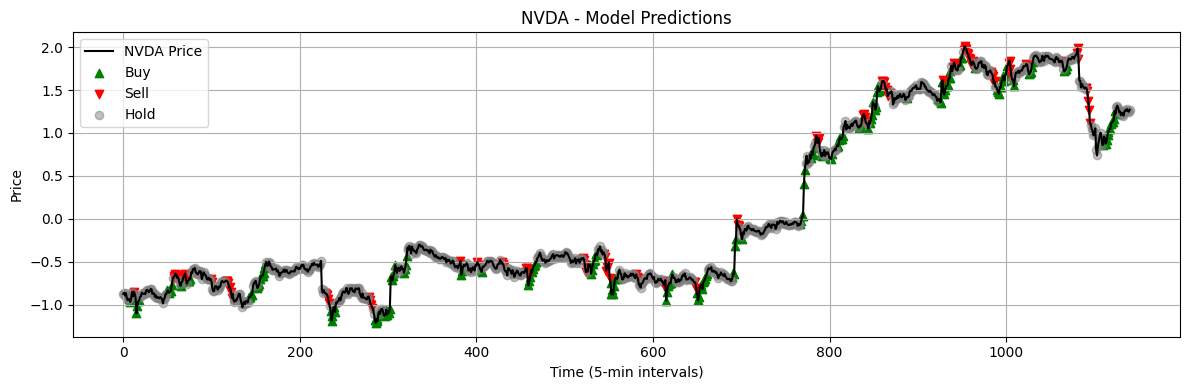

In [8]:
symbol = symbols[3]
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

print("\nClassification Report:")
pprint(format_floats(results[symbol]["classification_report"]))

print("\nConfusion Matrix:")
print(results[symbol]["confusion_matrix"])

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)

Metrics for TSLA:

Balanced Accuracy: 0.6919

Classification Report:
{'0': {'f1-score': '0.8958',
       'precision': '0.8409',
       'recall': '0.9584',
       'support': '794.0000'},
 '1': {'f1-score': '0.6909',
       'precision': '0.8636',
       'recall': '0.5758',
       'support': '165.0000'},
 '2': {'f1-score': '0.6405',
       'precision': '0.7840',
       'recall': '0.5414',
       'support': '181.0000'},
 'accuracy': '0.8368',
 'macro avg': {'f1-score': '0.7424',
               'precision': '0.8295',
               'recall': '0.6919',
               'support': '1140.0000'},
 'weighted avg': {'f1-score': '0.8256',
                  'precision': '0.8351',
                  'recall': '0.8368',
                  'support': '1140.0000'}}

Confusion Matrix:
[[761  11  22]
 [ 65  95   5]
 [ 79   4  98]]


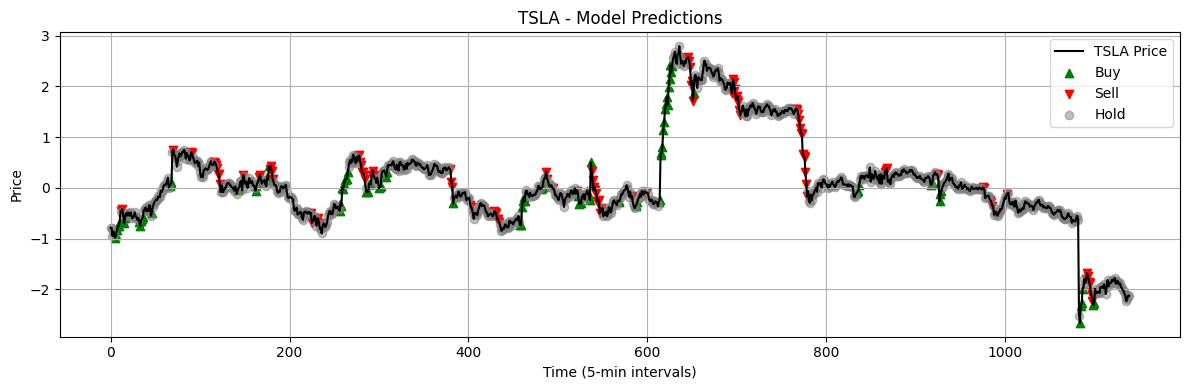

In [9]:
symbol = symbols[4]
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

print("\nClassification Report:")
pprint(format_floats(results[symbol]["classification_report"]))

print("\nConfusion Matrix:")
print(results[symbol]["confusion_matrix"])

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)